In [1]:
# TensorFlow and tf.keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
import pandas as pd

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import time


2.0.0-alpha0


Import data:

In [2]:
data = np.load('circles_data.npz')
circleData = data["circles"]
labels = np.column_stack((data['radiilab'],data['distlab']))
grid = 32
n_data = 1000
print(labels)

[[20. 19.  8.]
 [17. 22. 13.]
 [18. 25. 12.]
 ...
 [26. 29.  3.]
 [30. 24.  3.]
 [17. 28.  1.]]


Print a plot of data to see what it looks like!

radius1, radius2, distance between ceneters:
[26. 22.  6.]


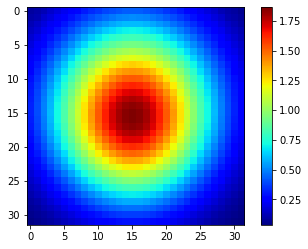

In [3]:
display = circleData[60].reshape(grid,grid)
plt.grid(False)
plt.imshow(display, cmap = 'jet')
print("radius1, radius2, distance between ceneters:")
print(labels[60])
plt.colorbar()

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

In [4]:
data = circleData.reshape(n_data, grid, grid, 1)
split = int(0.8*len(circleData))
train_data = data[:split]
train_labels = labels[:split]
print (train_data.shape)
test_data = data[split:]
print(test_data.shape)
test_labels = labels[split:]

(800, 32, 32, 1)
(200, 32, 32, 1)


Build DNN:

In [5]:
    model = keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        MaxPool2D((2, 2)),
#         Dropout(0.2),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        MaxPool2D((2, 2)),
#         Dropout(0.2),
        Flatten(),
        Dense(64, activation=tf.nn.relu),
        Dense(64, activation=tf.nn.relu),
#         Dropout(0.2),
        Dense(3, activation=tf.nn.relu)
      ])

    model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error', 'mean_absolute_error', 'accuracy'])
    return model

Initialize model:

In [6]:
circleCNN = build_model()

Test model's prediction $before$ training:

In [7]:
example_batch = train_data[:10]
example_labels = train_labels[:10]
example_result = circleCNN.predict(example_batch)
results = circleCNN.evaluate(example_batch, example_labels)
example_result

10/10 [==============================] - 0s 9ms/sample - loss: 383.8647 - mean_squared_error: 382.8871 - mean_absolute_error: 18.2276 - accuracy: 0.0000e+00


array([[0.        , 0.        , 0.01905614],
       [0.        , 0.        , 0.01755958],
       [0.        , 0.        , 0.02106578],
       [0.        , 0.        , 0.0265293 ],
       [0.        , 0.        , 0.02597972],
       [0.        , 0.        , 0.02343544],
       [0.        , 0.        , 0.01704027],
       [0.        , 0.        , 0.02491214],
       [0.        , 0.        , 0.02200143],
       [0.        , 0.        , 0.02161971]], dtype=float32)

Now train! (warning: if building CNN, computer tends to get loud)

In [8]:
 class PrintDot(keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs):
     if epoch % 100 == 0: 
         print('')
     print('.', end='')
    
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = checkpoint_path

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_best_only=True,
                                                 verbose=1)
    
 EPOCHS = 100
 early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
 history = circleCNN.fit(
   train_data, train_labels,
   epochs=EPOCHS, validation_split = 0.2, verbose = 1,
   callbacks=[early_stop])

Train on 640 samples, validate on 160 samples
Epoch 1/100
640/640 [==============================] - 1s 2ms/sample - loss: 292.5267 - mean_squared_error: 291.6921 - mean_absolute_error: 14.2861 - accuracy: 0.3781 - val_loss: 208.1382 - val_mean_squared_error: 207.4365 - val_mean_absolute_error: 11.2980 - val_accuracy: 0.5500
Epoch 2/100
640/640 [==============================] - 1s 2ms/sample - loss: 201.9806 - mean_squared_error: 201.3639 - mean_absolute_error: 10.4540 - accuracy: 0.4922 - val_loss: 192.5021 - val_mean_squared_error: 191.9645 - val_mean_absolute_error: 10.0898 - val_accuracy: 0.5500
Epoch 3/100
640/640 [==============================] - 1s 2ms/sample - loss: 199.1608 - mean_squared_error: 198.6720 - mean_absolute_error: 10.2737 - accuracy: 0.4922 - val_loss: 193.3582 - val_mean_squared_error: 192.9141 - val_mean_absolute_error: 10.1773 - val_accuracy: 0.5500
Epoch 4/100
640/640 [==============================] - 1s 2ms/sample - loss: 198.8329 - mean_squared_error: 198

640/640 [==============================] - 1s 2ms/sample - loss: 9.7796 - mean_squared_error: 9.4728 - mean_absolute_error: 2.4788 - accuracy: 0.5797 - val_loss: 9.3128 - val_mean_squared_error: 9.0061 - val_mean_absolute_error: 2.3830 - val_accuracy: 0.5500
Epoch 31/100
640/640 [==============================] - 1s 2ms/sample - loss: 9.5956 - mean_squared_error: 9.2890 - mean_absolute_error: 2.4402 - accuracy: 0.5797 - val_loss: 9.1741 - val_mean_squared_error: 8.8677 - val_mean_absolute_error: 2.3834 - val_accuracy: 0.5500
Epoch 32/100
640/640 [==============================] - 1s 2ms/sample - loss: 9.6566 - mean_squared_error: 9.3503 - mean_absolute_error: 2.4201 - accuracy: 0.5906 - val_loss: 9.9824 - val_mean_squared_error: 9.6765 - val_mean_absolute_error: 2.5002 - val_accuracy: 0.5375
Epoch 33/100
640/640 [==============================] - 1s 2ms/sample - loss: 9.4123 - mean_squared_error: 9.1065 - mean_absolute_error: 2.4068 - accuracy: 0.6000 - val_loss: 8.7727 - val_mean_squa

640/640 [==============================] - 1s 1ms/sample - loss: 2.4980 - mean_squared_error: 2.1902 - mean_absolute_error: 1.0222 - accuracy: 0.8656 - val_loss: 1.6994 - val_mean_squared_error: 1.3917 - val_mean_absolute_error: 0.7791 - val_accuracy: 0.9125
Epoch 61/100
640/640 [==============================] - 1s 1ms/sample - loss: 2.8409 - mean_squared_error: 2.5337 - mean_absolute_error: 1.1413 - accuracy: 0.8313 - val_loss: 2.9100 - val_mean_squared_error: 2.6037 - val_mean_absolute_error: 1.2943 - val_accuracy: 0.8125
Epoch 62/100
640/640 [==============================] - 1s 1ms/sample - loss: 2.5106 - mean_squared_error: 2.2047 - mean_absolute_error: 0.9842 - accuracy: 0.8719 - val_loss: 1.9128 - val_mean_squared_error: 1.6072 - val_mean_absolute_error: 0.9254 - val_accuracy: 0.8438
Epoch 63/100
640/640 [==============================] - 1s 1ms/sample - loss: 2.3387 - mean_squared_error: 2.0331 - mean_absolute_error: 0.9718 - accuracy: 0.8672 - val_loss: 2.1480 - val_mean_squa

Now make a plot that shows the pregression of accuracy through each training epoch.

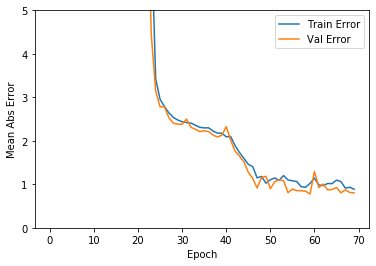

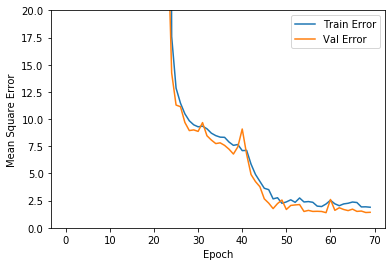

In [9]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

Load best weights.

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

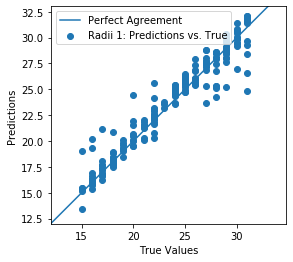

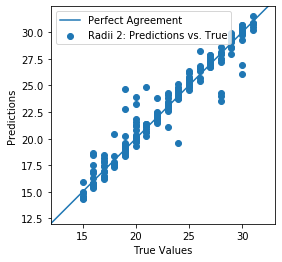

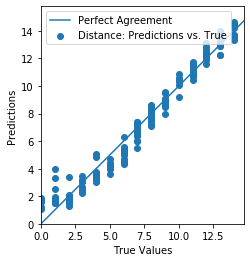

In [13]:
test_predictions = circleCNN.predict(test_data)
plt.figure()
plt.scatter(test_labels[:,0], test_predictions[:,0], label='Radii 1: Predictions vs. True')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([12,plt.xlim()[1]])
plt.ylim([12,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100], label="Perfect Agreement")
plt.legend(loc='upper left')
plt.figure()
plt.scatter(test_labels[:,1], test_predictions[:,1], label='Radii 2: Predictions vs. True')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([12,plt.xlim()[1]])
plt.ylim([12,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100], label="Perfect Agreement")
plt.legend(loc='upper left')
plt.figure()
plt.scatter(test_labels[:,2], test_predictions[:,2], label='Distance: Predictions vs. True')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100], label="Perfect Agreement")
plt.legend(loc='upper left')